In [1]:
import numpy as np
import pylab as pl
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow
import keras


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#from google.colab import files

# Upload the file
#uploaded = files.upload()

## Loading the data

For both datasets do the following:


1. *Load the data with np.load("filename.npz") and store the different matrices in memory (for instance in variables $x_1$, $y_1$ for Pima data and $x_2$, $y_2$, $xt_2$, $yt_2$ for digits data). For the digits dataset, it is better to perform one simple pre-processing that scales the values between [0, 1] by dividing the data matrix by 255.*

In [4]:
# Load Pima dataset
pima = np.load("pima.npz")
x1 = pima['xall']
y1 = pima['yall']

# Load digits dataset
digits = np.load("digits_TP3.npz")
x2 = digits['x']/255
y2 = digits['y']
xt2 = digits['xt']/255
yt2 = digits['yt']


2. *Do a quick look at the data, compute the mean values for each variable and interpret it.*

In [5]:
# For Pima dataset
print("Pima Dataset:")
print("Number of samples:", x1.shape[0])
print("Number of features:", x1.shape[1])
print("Mean values for each variable:")
for i in range(x1.shape[1]):
    mean_value = np.mean(x1[:, i])
    print(f"Variable {i+1}: {mean_value:.2f}")

# For digits dataset
print("\nDigits Dataset:")
print("Number of training samples:", x2.shape[0])
print("Number of test samples:", xt2.shape[0])
print("Number of features for each sample:", x2.shape[1])
print("Mean values for each variable:")
for i in range(x2.shape[1]):
    mean_value = np.mean(x2[:, i])
    print(f"Variable {i+1}: {mean_value:.2f}")

Pima Dataset:
Number of samples: 709
Number of features: 8
Mean values for each variable:
Variable 1: 3.75
Variable 2: 121.61
Variable 3: 69.64
Variable 4: 20.77
Variable 5: 80.53
Variable 6: 32.45
Variable 7: 0.47
Variable 8: 33.02

Digits Dataset:
Number of training samples: 3000
Number of test samples: 1500
Number of features for each sample: 784
Mean values for each variable:
Variable 1: 0.00
Variable 2: 0.00
Variable 3: 0.00
Variable 4: 0.00
Variable 5: 0.00
Variable 6: 0.00
Variable 7: 0.00
Variable 8: 0.00
Variable 9: 0.00
Variable 10: 0.00
Variable 11: 0.00
Variable 12: 0.00
Variable 13: 0.00
Variable 14: 0.00
Variable 15: 0.00
Variable 16: 0.00
Variable 17: 0.00
Variable 18: 0.00
Variable 19: 0.00
Variable 20: 0.00
Variable 21: 0.00
Variable 22: 0.00
Variable 23: 0.00
Variable 24: 0.00
Variable 25: 0.00
Variable 26: 0.00
Variable 27: 0.00
Variable 28: 0.00
Variable 29: 0.00
Variable 30: 0.00
Variable 31: 0.00
Variable 32: 0.00
Variable 33: 0.00
Variable 34: 0.00
Variable 35: 0

In [6]:
attributes=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
mean_pima = x1.mean(axis=0)
for i in range(len(attributes)):
  print(attributes[i]+" mean: "+"{:.2f}".format(mean_pima[i]))


Pregnancies mean: 3.75
Glucose mean: 121.61
BloodPressure mean: 69.64
SkinThickness mean: 20.77
Insulin mean: 80.53
BMI mean: 32.45
DiabetesPedigreeFunction mean: 0.47
Age mean: 33.02


*Comment:* Concerning each variable, we observe a high average number of pregnancies per patient; a more important Glucose concentration than the normal concentration (100), so we probably have more diabetic patients than nondiabetic ones. Moreover, the high mean value of DiabetesPedigree reflects that there is a high probability of transmitting the disease through generations.

# Predicting Diabetes on the Pima dataset

On this dataset we will evaluate the performance of the classifier with the accuracy and with the AUC.

## Know the data

1. *Visualize the data as scatterplots between pairs of variables (where the color is the class).*


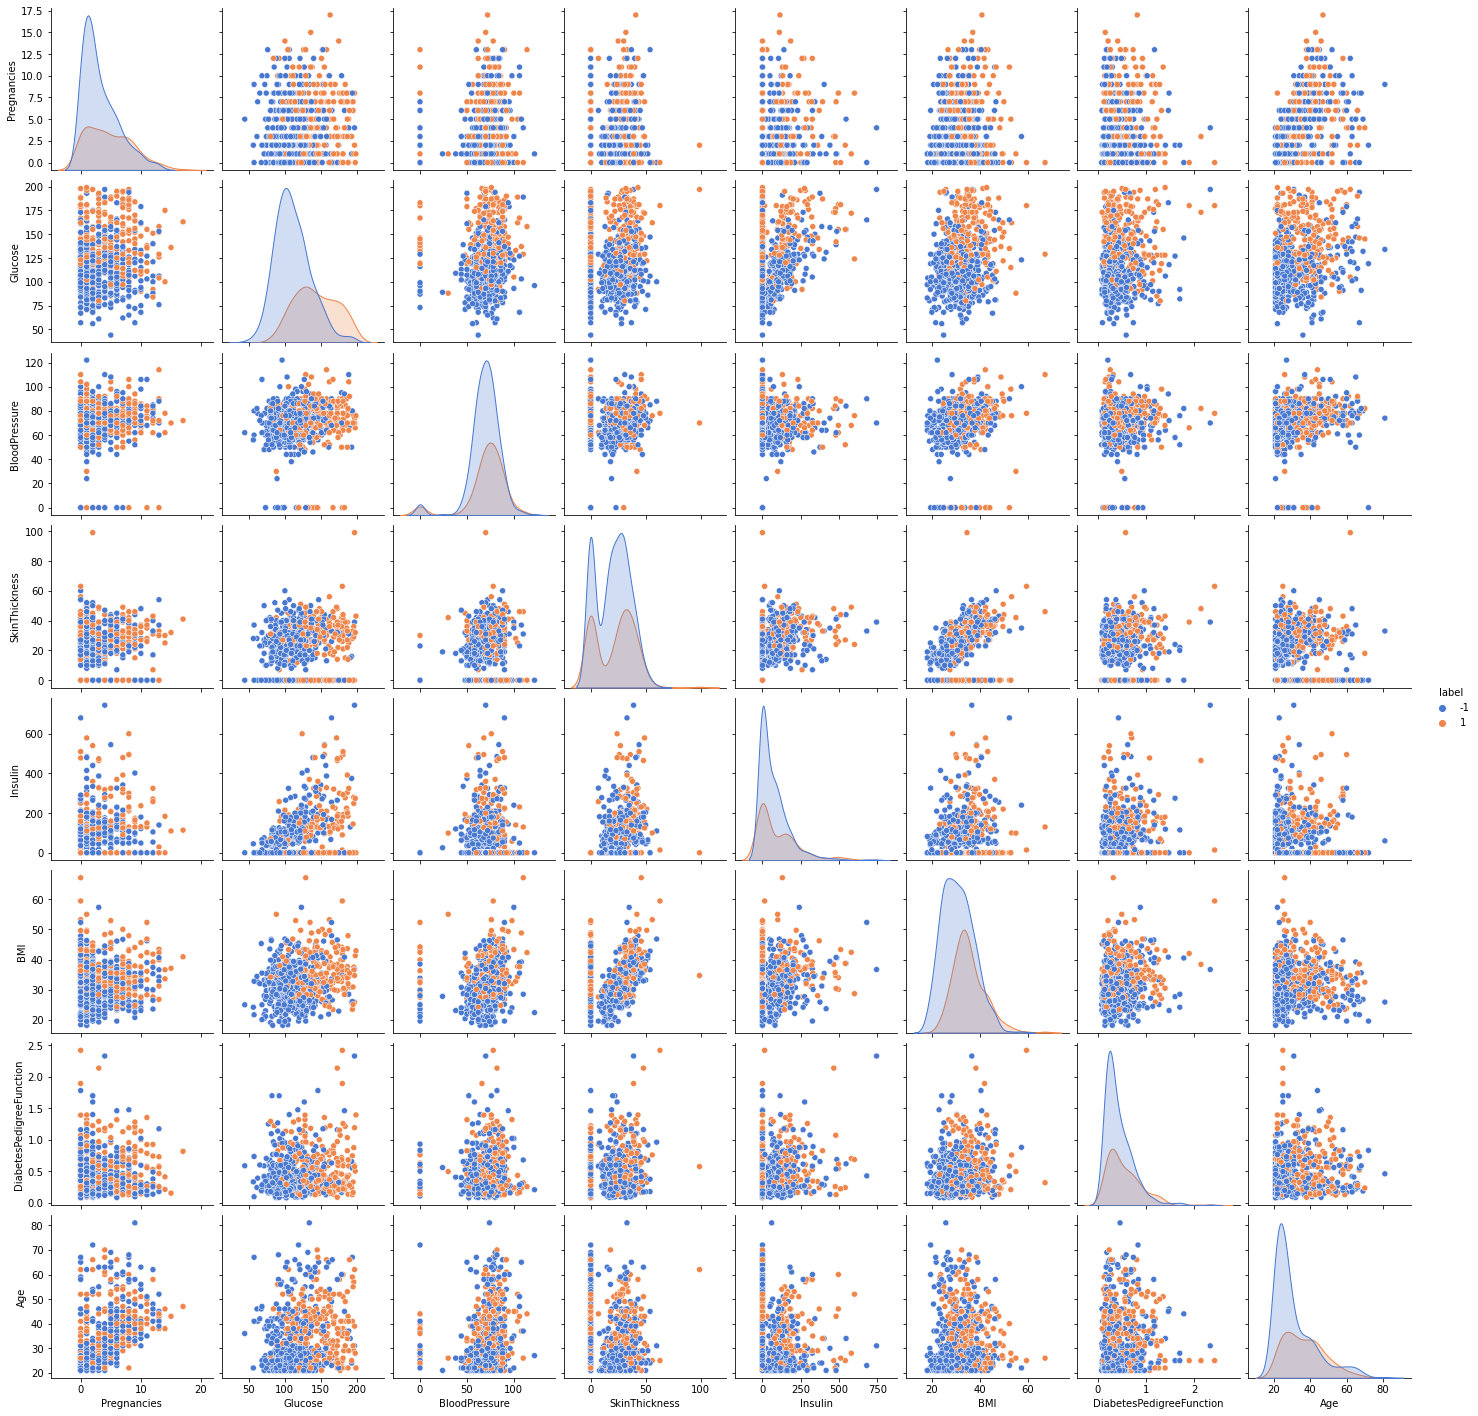

In [7]:
df1 = pd.DataFrame(x1, columns=attributes)
df1["label"]=y1
sns.pairplot(df1, hue="label", palette="muted")

2. *What are the variables that seem to help predict the class? Do those variable make sense from a medical perspective ?*

Variables that seem to help predict the class: From the scatterplots, Glucose and BMI appear to be significant predictors. Pregnancies and Age also show distinguishable patterns.

Medical Perspective: Glucose levels and BMI are known factors in diabetes diagnosis. Age and pregnancies also align with medical understanding.

Upon examining the PairGrid above, it is apparent that certain variables appear to be useful in predicting the data class. For instance, the “Glucose” variable, when included in the scatterplots, separates the data points into two distinct clusters. Patients with diabetes typically exhibit high glucose levels, while those with low glucose concentrations generally do not have diabetes. Furthermore, the two distributions of Glucose concentrations, when plotted according to their classes, have separate supports. This variable is medically significant as it is well-known that diabetes is strongly associated with glucose concentration.

The variable BMI also appears to be correlated with Glucose, suggesting it may be helpful in making predictions. When we consider scatterplots that include the Age variable, we observe that subjects with diabetes tend to be older.

3. *Split the data in training/test by keeping n = 300 samples for training/validation and the remaining
for test.*

In [8]:
from sklearn.model_selection import train_test_split

n=300
#Way 1
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=len(x1)-n, random_state=42)

#Way 2
x1_train, x1_test = x1[:n,:], x1[n:,:]
y1_train, y1_test = y1[:n], y1[n:]


4. *Do the feature have similar variances/scaling? Is that a problem?*

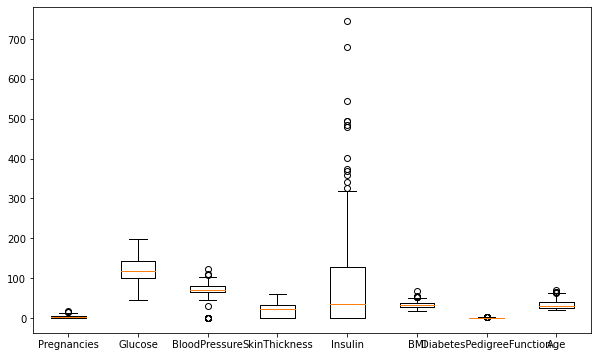

Pregnancies std: 3.32
Glucose std: 30.02
BloodPressure std: 17.89
SkinThickness std: 15.65
Insulin std: 116.10
BMI std: 7.29
DiabetesPedigreeFunction std: 0.33
Age std: 10.85


In [9]:
pl.figure(figsize=(10,6))
pl.boxplot(x1_train, labels=attributes)
pl.show()

std_pima = x1_train.std(axis=0)
for i in range(len(attributes)):
  print(attributes[i]+" std: "+"{:.2f}".format(std_pima[i]))

*Comment:* As we can see in the boxplot, the features have large different values of variances. It can be a problem for some ML algorithms because they might give more importance to features with larger variances. That is why we apply standardization to make all features have zero mean and unit variance.

5. *Apply a standardization to the training and test data (StandardScaler).*

In [10]:
from sklearn.preprocessing import StandardScaler

# Apply standardization to the training and test data
scaler = StandardScaler()
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)

# Check variances of the features after standardization
print("\nVariances after standardization:")
print(np.var(x1_train, axis=0))



Variances after standardization:
[1. 1. 1. 1. 1. 1. 1. 1.]


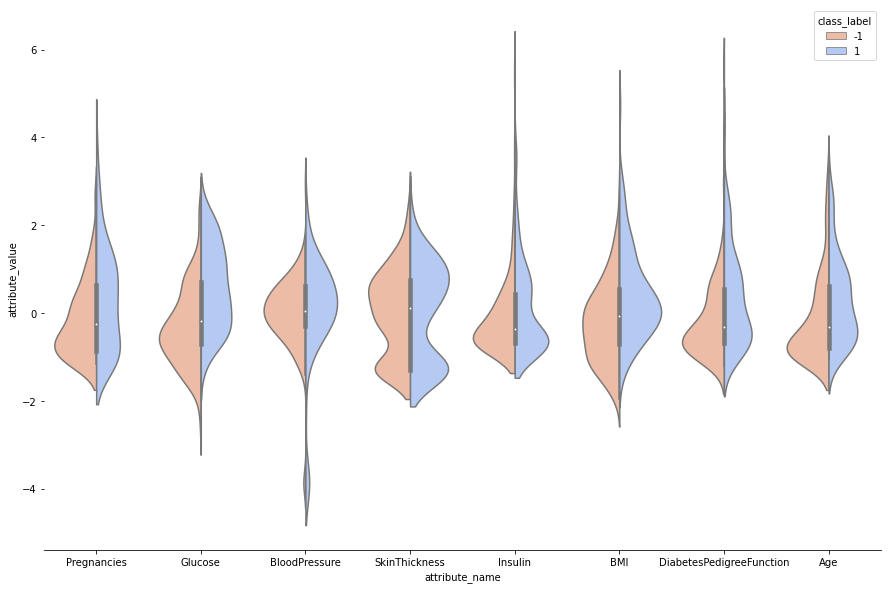

The standard deviation of Pregnancies is: 1.00
The standard deviation of Glucose is: 1.00
The standard deviation of BloodPressure is: 1.00
The standard deviation of SkinThickness is: 1.00
The standard deviation of Insulin is: 1.00
The standard deviation of BMI is: 1.00
The standard deviation of DiabetesPedigreeFunction is: 1.00
The standard deviation of Age is: 1.00


In [11]:
df2 = pd.DataFrame(columns=["attribute_name", "attribute_value", "class_label"])


for index in range(len(attributes)):
  attribute = attributes[index]

  for sample_index in range(x1_train.shape[0]):
    # Append the attribute name, its value, and the corresponding class label to the DataFrame
    df2 = df2.append({"attribute_name": attribute, "attribute_value": x1_train[sample_index, index], "class_label": y1[sample_index]}, ignore_index=True)


pl.figure(figsize=(15, 10))
sns.violinplot(x="attribute_name", y="attribute_value", hue="class_label", data=df2, palette="coolwarm_r", split=True)
sns.despine(left=True)
pl.show()


std_pima = x1_train.std(axis=0)
for index in range(len(attributes)):
  print(f"The standard deviation of {attributes[index]} is: {std_pima[index]:.2f}")


*Comment:* Now, we can see how features are scaled.

## Bayesian decision and linear classification

1. *Train a Linear Discriminant Analysis (LDA) classifier with the default parameters, compute its accuracy and AUC on the test data (LinearDiscriminantAnalysis,roc_auc_score). Note that in order to compute the AUC you will need to compute the score with est.predict_proba and keep the second
column (probability of the class 1).*




In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score

# Train LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(x1_train, y1_train)

# Predict and evaluate accuracy
lda_predictions = lda.predict(x1_test)
accuracy_lda = accuracy_score(y1_test, lda_predictions)

# Compute AUC
lda_probabilities = lda.predict_proba(x1_test)[:, 1]
auc_lda = roc_auc_score(y1_test, lda_probabilities)

print("LDA Classifier:")
print("Accuracy:", accuracy_lda)
print("AUC:", auc_lda)


LDA Classifier:
Accuracy: 0.7946210268948656
AUC: 0.8636637129416913


2. *Perform a cross validation (GridSearchCV) for the parameters of the method (shrinkage). Does the validation leads to better performance? What is the optimal value for the parameter?*

In [13]:
from sklearn.model_selection import GridSearchCV

# Perform cross validation for the LDA classifier
param_grid = {'shrinkage': np.linspace(0, 1, 50), "solver":['lsqr','eigen']}
cv = GridSearchCV(LinearDiscriminantAnalysis(), param_grid)
cv.fit(x1_train, y1_train)

lda_best = cv.best_estimator_
lda_best.fit(x1_train, y1_train)
print("Best parameters for LDA: ", cv.best_params_)

# Compute accuracy and AUC on the test data
y1_pred_lda_best = lda_best.predict(x1_test)
y1_prob_lda_best = lda_best.predict_proba(x1_test)[:, 1]
accuracy_lda_best = accuracy_score(y1_test, y1_pred_lda_best)
auc_lda_best = roc_auc_score(y1_test, y1_prob_lda_best)
print("Best LDA Accuracy: ", accuracy_score(y1_test, y1_pred_lda_best))
print("Best LDA AUC: ", roc_auc_score(y1_test, y1_prob_lda_best))

Best parameters for LDA:  {'shrinkage': 0.02040816326530612, 'solver': 'lsqr'}
Best LDA Accuracy:  0.7970660146699267
Best LDA AUC:  0.8642927469642271


*Comment:* Unsurprisingly, we observe that the cross validation for the parameter "shrinkage" increases the performance. Indeed, the AUC and the accuracy is better comparatively to the default LDA.

3. *Train a Quadratic Discriminant Analysis (QDA) classifier with the default parameters, compute its accuracy and AUC on the test data (QuadraticDiscriminantAnalysis). Is the performance better
than LDA?*

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Train a QDA classifier
qda = QuadraticDiscriminantAnalysis()
qda.fit(x1_train, y1_train)

# Compute accuracy and AUC on the test data
y1_pred_qda = qda.predict(x1_test)
y1_prob_qda = qda.predict_proba(x1_test)[:, 1]
accuracy_qda = accuracy_score(y1_test, y1_pred_qda)
auc_qda = roc_auc_score(y1_test, y1_prob_qda)
print("QDA Accuracy: ", accuracy_score(y1_test, y1_pred_qda))
print("QDA AUC: ", roc_auc_score(y1_test, y1_prob_qda))


QDA Accuracy:  0.7603911980440098
QDA AUC:  0.8109342522699924


*Comment:* Default QDA model performs worsely than the LDA model.

4. *Perform a cross validation for the parameters of the method (reg_param). Does the validation leads to better performance? What is the optimal value for the parameter.*

In [15]:
from sklearn.model_selection import GridSearchCV

# Perform cross validation for the QDA classifier
param_grid = {'reg_param': np.linspace(0, 1, 50)}
cv = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid)
cv.fit(x1_train, y1_train)

qda_best = cv.best_estimator_
qda_best.fit(x1_train, y1_train)
print("Best parameters for QDA: ", cv.best_params_)

# Compute accuracy and AUC on the test data
y1_pred_qda_best = qda_best.predict(x1_test)
y1_prob_qda_best = qda_best.predict_proba(x1_test)[:, 1]
accuracy_qda_best = accuracy_score(y1_test, y1_pred_qda_best)
auc_qda_best = roc_auc_score(y1_test, y1_prob_qda_best)
print("Best QDA Accuracy: ", accuracy_score(y1_test, y1_pred_qda_best))
print("Best QDA AUC: ", roc_auc_score(y1_test, y1_prob_qda_best))

Best parameters for QDA:  {'reg_param': 0.6122448979591836}
Best QDA Accuracy:  0.8019559902200489
Best QDA AUC:  0.8575101192429713


*Comment:* The cross-validation for the "reg_param" parameter notably increased the AUC and accuracy compared to the default QDA model.

5. *Train a Gaussian Naive Bayes (NB) classifier (GaussianNB). What is its performance with respect to
QDA and LDA?*

In [16]:
from sklearn.naive_bayes import GaussianNB

# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(x1_train, y1_train)

# Compute accuracy and AUC on the test data
y1_pred_gnb = gnb.predict(x1_test)
y1_prob_gnb = gnb.predict_proba(x1_test)[:, 1]
accuracy_gnb = accuracy_score(y1_test, y1_pred_gnb)
auc_gnb = roc_auc_score(y1_test, y1_prob_gnb)
print("GaussianNB Accuracy: ", accuracy_score(y1_test, y1_pred_gnb))
print("GaussianNB AUC: ", roc_auc_score(y1_test, y1_prob_gnb))

GaussianNB Accuracy:  0.7677261613691931
GaussianNB AUC:  0.8310359916858113


*Comment:* The QDA and LDA models have shown better resulats in terms of performance on test dataset comparatively to the Gaussian Naive Bayes model, except for the default QDA model.

6. *Train a Logistic regression classifier (LogisticRegression) with the default parameters. Compute its performance and compare it to the previous classifiers.*

In [17]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression classifier
lr = LogisticRegression()
lr.fit(x1_train, y1_train)

# Compute accuracy and AUC on the test data
y1_pred_lr = lr.predict(x1_test)
y1_prob_lr = lr.predict_proba(x1_test)[:, 1]
accuracy_lr = accuracy_score(y1_test, y1_pred_lr)
auc_lr = roc_auc_score(y1_test, y1_prob_lr)
print("Logistic Regression Accuracy: ", accuracy_score(y1_test, y1_pred_lr))
print("Logistic Regression AUC: ", roc_auc_score(y1_test, y1_prob_lr))


Logistic Regression Accuracy:  0.7946210268948656
Logistic Regression AUC:  0.8647576851547971


*Comment:* When we compare the performance metrics of the logistic regressor with other models, it’s evident that the logistic regressor outperforms both the Gaussian Naive Bayes model and the QDA model. However, while the accuracy of the logistic regressor is marginally lower than that of the LDA, its AUC is slightly higher. The performance of the logistic regressor and LDA are fairly comparable, with the logistic regressor having a slight edge. This advantage can be attributed to the ability to select a threshold for the logistic regressor classifier other than (the default value provided by the scikit-learn package), which can enhance accuracy.

7. *Perform a a cross validation for the parameters of the model (C) by setting the penalization to L1. Is the model sparse? What variables were removed from the model? Is the classifier performing well?*

In [18]:
from sklearn.model_selection import GridSearchCV

# Perform cross validation for the LR classifier
param_grid = {'C': np.linspace(0, 3, 150), 'solver':['liblinear','saga']}
cv = GridSearchCV(LogisticRegression(penalty='l1', max_iter=200, random_state=123), param_grid)
cv.fit(x1_train, y1_train)

lr_best = cv.best_estimator_
lr_best.fit(x1_train, y1_train)
print("Best parameters for LR: ", cv.best_params_)

# Compute accuracy and AUC on the test data
y1_pred_lr_best = lr_best.predict(x1_test)
y1_prob_lr_best = lr_best.predict_proba(x1_test)[:, 1]
accuracy_lr_best = accuracy_score(y1_test, y1_pred_lr_best)
auc_lr_best = roc_auc_score(y1_test, y1_prob_lr_best)
print("Best LR Accuracy: ", accuracy_score(y1_test, y1_pred_lr_best))
print("Best LR AUC: ", roc_auc_score(y1_test, y1_prob_lr_best))

Best parameters for LR:  {'C': 0.28187919463087246, 'solver': 'saga'}
Best LR Accuracy:  0.80440097799511
Best LR AUC:  0.8685865879006673


In [19]:
print("Coefficients: ", lr_best.coef_)

removed_variables = np.array(attributes)[lr_best.coef_[0] == 0]
print("Removed variables: ", removed_variables)

Coefficients:  [[ 0.36968931  0.86591917 -0.01671841 -0.09856632 -0.18924964  0.61078505
   0.41397803  0.        ]]
Removed variables:  ['Age']


*Comment:* We can observe that the accuracy decreased a little when the AUC increased a little. However, the model still performing well comparatively to the other ones.

If the L1 penalty worked as intended, some of the coefficients should be exactly zero, indicating a sparse model. Thus, by examining the coefficients of lr_best model, we can conclude that the model is sparse.

 The variables corresponding to the zero coefficients were removed by the L1 penalty. Therefore the removed variables are 'Age'.


8. *What is the best decision method so far? Is the best model linear (LAD,LR) on quadratic (QDA,NB)?*

The best decision method is determined by comparing the accuracy and AUC scores for each classifier. Here, the best model is the best Logistic Regression (followed by QDA). Moreover, in average, the linear models seems to have greater performance metrics.


9. *Interpret the separability of the sample in the predicted score space by plotting histograms for the
samples for each class in 1D.*

To interpret separability, you can plot histograms for each class in 1D using predicted scores. For example, for LDA predictions:

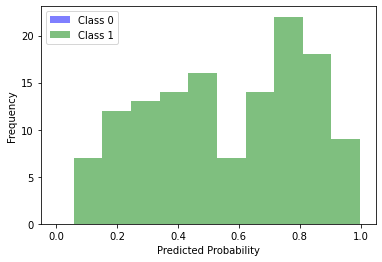

In [20]:
plt.hist(lda_probabilities[y1_test == 0], alpha=0.5, label='Class 0', color='blue')
plt.hist(lda_probabilities[y1_test == 1], alpha=0.5, label='Class 1', color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

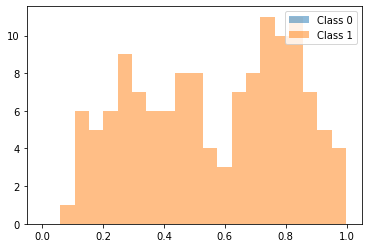

In [21]:
# Plot histograms for the samples for each class in 1D
plt.hist(y1_prob_lda_best[y1_test==0], bins=20, alpha=0.5, label='Class 0')
plt.hist(y1_prob_lda_best[y1_test==1], bins=20, alpha=0.5, label='Class 1')
plt.legend(loc='upper right')
plt.show()

10. *Interpret the weight for a good linear model. What is the effect of each variable on the risk of diabetes?
Does it make medical sense?*

In [22]:
# Interpret the weight for a good linear model (e.g., LDA)
for i in range(len(df1.columns)-1):
    print(f"Effect of {df1.columns[i]} on the risk of diabetes: {lda_best.coef_[0][i]}")

Effect of Pregnancies on the risk of diabetes: 0.5021197049257449
Effect of Glucose on the risk of diabetes: 1.0642855937119091
Effect of BloodPressure on the risk of diabetes: -0.07871753823434638
Effect of SkinThickness on the risk of diabetes: -0.18936654442913836
Effect of Insulin on the risk of diabetes: -0.3122892520202753
Effect of BMI on the risk of diabetes: 0.7799104545909175
Effect of DiabetesPedigreeFunction on the risk of diabetes: 0.5346342079153632
Effect of Age on the risk of diabetes: -0.019501044362939632


As we observed initially, Glucose concentration is the most significant feature. Other key features include BMI, DiabetesPedigreeFunction, and Pregnancies. The l1 regularizer slightly reduced the weights of these variables. They have a positive correlation with diabetes cases. Indeed, patients with diabetes tend to exhibit high values of Glucose, BMI, DiabetesPedigreeFunction (indicating a higher likelihood of developing diabetes if it's a hereditary disease), and the number of pregnancies. Other variables such as Age, BloodPressure, and SkinThickness were eliminated by the model, and their weights are set to zero, indicating they don't significantly influence the prediction. The weight of the Insulin variable was decreased. This variable has a negative weight, implying that diabetic subjects, who typically have low insulin levels due to insufficient insulin production to lower glucose concentration, are associated with lower insulin rates.

So far, the best results have been achieved with linear models (LDA, LR) as opposed to quadratic models (QDA, GNB).

## Nonlinear methods

For the following non-linear classifiers, RandomForestClassifier, SVC, MLPClassifier,
GradientBoostingClassifier do the following:

1. *Fit the model with the default parameters and compute its prediction performance. Is it better than a linear estimator?*

**RandomForestClassifier**

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest classifier with default parameters
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x1_train, y1_train)

# Predict and evaluate performance
rf_predictions = rf_classifier.predict(x1_test)
accuracy_rf = accuracy_score(y1_test, rf_predictions)
auc_rf = roc_auc_score(y1_test, rf_classifier.predict_proba(x1_test)[:, 1])

print("Random Forest Classifier:")
print("Accuracy:", accuracy_rf)
print("AUC:", auc_rf)


Random Forest Classifier:
Accuracy: 0.7750611246943765
AUC: 0.8502625533311454


*Comment:* The RF classifier with default parameters does not show better performance than any other linear models (LDA and logistic regressor).

**SupportVectorClassifier**

In [24]:
from sklearn.svm import SVC

# Train SVC classifier with default parameters
svc_classifier = SVC(probability=True, random_state=42)
svc_classifier.fit(x1_train, y1_train)

# Predict and evaluate performance
svc_predictions = svc_classifier.predict(x1_test)
accuracy_svc = accuracy_score(y1_test, svc_predictions)
auc_svc = roc_auc_score(y1_test, svc_classifier.predict_proba(x1_test)[:, 1])

print("Support Vector Classifier (SVC):")
print("Accuracy:", accuracy_svc)
print("AUC:", auc_svc)


Support Vector Classifier (SVC):
Accuracy: 0.7872860635696821
AUC: 0.8385023520402581


*Comment:* The default SVC model performance is worse than the linear models ones. However, we can notice that the SVC accuracy is close to the logistic regression one.

**MLPClassifier**

In [25]:
from sklearn.neural_network import MLPClassifier

# Train MLP classifier with default parameters
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(x1_train, y1_train)

# Predict and evaluate performance
mlp_predictions = mlp_classifier.predict(x1_test)
accuracy_mlp = accuracy_score(y1_test, mlp_predictions)
auc_mlp = roc_auc_score(y1_test, mlp_classifier.predict_proba(x1_test)[:, 1])

print("Multi-Layer Perceptron (MLP) Classifier:")
print("Accuracy:", accuracy_mlp)
print("AUC:", auc_mlp)


Multi-Layer Perceptron (MLP) Classifier:
Accuracy: 0.784841075794621
AUC: 0.8525598949786676


*Comment:* Again, the default MLP classifier performance is not better than the linear models.

**GradientBoostingClassifier**

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting classifier with default parameters
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(x1_train, y1_train)

# Predict and evaluate performance
gb_predictions = gb_classifier.predict(x1_test)
accuracy_gb = accuracy_score(y1_test, gb_predictions)
auc_gb = roc_auc_score(y1_test, gb_classifier.predict_proba(x1_test)[:, 1])

print("Gradient Boosting Classifier:")
print("Accuracy:", accuracy_gb)
print("AUC:", auc_gb)


Gradient Boosting Classifier:
Accuracy: 0.7555012224938875
AUC: 0.829121540312876


*Comment:* Again, the default gradient boosting performance is not as good as the linear models.

2. *Do a quick validation of some of the important parameters (manually or with sklearn classes). Can you find a better performance?*

**RandomForestClassifier**

In [27]:
from sklearn.model_selection import GridSearchCV

# Perform GridSearchCV for Random Forest parameters
param_grid_rf = {'n_estimators': [50, 100, 150],
                 'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 5, 10]}

rf_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
rf_cv.fit(x1_train, y1_train)

# Get best parameters and score
rf_opt = rf_cv.best_estimator_
best_n_estimators = rf_cv.best_params_['n_estimators']
best_max_depth = rf_cv.best_params_['max_depth']
best_min_samples_split = rf_cv.best_params_['min_samples_split']
rf_cv_score = rf_cv.best_score_

print("Best Parameters for Random Forest Classifier:")
print("n_estimators:", best_n_estimators)
print("max_depth:", best_max_depth)
print("min_samples_split:", best_min_samples_split)
print("Cross-Validation Score for Random Forest:", rf_cv_score)


Best Parameters for Random Forest Classifier:
n_estimators: 150
max_depth: 10
min_samples_split: 10
Cross-Validation Score for Random Forest: 0.72


In [28]:
# Predict and evaluate performance
rf_predictions = rf_opt.predict(x1_test)
accuracy_rf_best = accuracy_score(y1_test, rf_predictions)
auc_rf_best = roc_auc_score(y1_test, rf_opt.predict_proba(x1_test)[:, 1])

print("Best Random Forest Classifier:")
print("Accuracy:", accuracy_rf_best)
print("AUC:", auc_rf_best)

Best Random Forest Classifier:
Accuracy: 0.7799511002444988
AUC: 0.8555409692593807


*Comment:* By adjusting the "max_features" hyperparameter, we were able to enhance the accuracy of the random forest classifier. However, this resulted in a slight decrease in the AUC. Despite the improved accuracy, the resulting model still falls short when compared to the linear models.

**SVC**

In [29]:
param_grid_svc = {'C': np.linspace(0.1,10,50),
                  'gamma': [1, 0.1, 0.01, 0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid']}
svc_cv = GridSearchCV(SVC(random_state=42, probability=True), param_grid_svc, cv=5)
svc_cv.fit(x1_train, y1_train)

svc_opt = svc_cv.best_estimator_
svc_cv_score = svc_cv.best_score_
print("Best Parameters for SVC:", svc_cv.best_params_)
print("Cross-Validation Score for SVC:", svc_cv_score)

Best Parameters for SVC: {'C': 9.595918367346938, 'gamma': 0.01, 'kernel': 'rbf'}
Cross-Validation Score for SVC: 0.77


In [30]:
svc_predictions = svc_opt.predict(x1_test)
accuracy_svc_best = accuracy_score(y1_test, svc_predictions)
auc_svc_best = roc_auc_score(y1_test, svc_opt.predict_proba(x1_test)[:, 1])

print("Best SVC:")
print("Accuracy:", accuracy_svc_best)
print("AUC:", auc_svc_best)

Best SVC:
Accuracy: 0.7872860635696821
AUC: 0.8587681872880428


*Comment:* Upon performing cross-validation on the "C" parameter of the SVC model, we observed a minor enhancement in the accuracy value. However, this was accompanied by a reduction in the AUC value.

**MLPClassifier**

In [31]:
param_grid_mlp = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                  'activation': ['tanh', 'relu'],
                  'solver': ['sgd', 'adam']}
mlp_cv = GridSearchCV(MLPClassifier(random_state=42), param_grid_mlp, cv=5)
mlp_cv.fit(x1_train, y1_train)

mlp_opt = mlp_cv.best_estimator_
mlp_cv_score = mlp_cv.best_score_
print("Best Parameters for MLP:", mlp_cv.best_params_)
print("Cross-Validation Score for MLP:", mlp_cv_score)

Best Parameters for MLP: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Cross-Validation Score for MLP: 0.7566666666666666


In [32]:
# Predict and evaluate performance
mlp_predictions = mlp_opt.predict(x1_test)
accuracy_mlp_best = accuracy_score(y1_test, mlp_predictions)
auc_mlp_best = roc_auc_score(y1_test, mlp_opt.predict_proba(x1_test)[:, 1])

print("Best MLP:")
print("Accuracy:", accuracy_mlp_best)
print("AUC:", auc_mlp_best)

Best MLP:
Accuracy: 0.7995110024449877
AUC: 0.8638551580789848


*Comment:* Through cross-validation, we managed to achieve a minor increase in both accuracy and AUC. However, these improvements still don't surpass the performance of the linear models.

**GradientBoostingClassifier**

In [33]:
param_grid_gbc = {'max_features': np.linspace(0.1,0.9,50),
                  'subsample': [0.3,0.4,0.5,0.6,0.7]}
gbc_cv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbc, cv=5)
gbc_cv.fit(x1_train, y1_train)

gbc_opt = gbc_cv.best_estimator_
gbc_cv_score = gbc_cv.best_score_
print("Best Parameters for Gradient Boosting Classifier:", gbc_cv.best_params_)
print("Cross-Validation Score for Gradient Boosting Classifier:", gbc_cv_score)

Best Parameters for Gradient Boosting Classifier: {'max_features': 0.37755102040816324, 'subsample': 0.5}
Cross-Validation Score for Gradient Boosting Classifier: 0.7333333333333333


In [34]:
# Predict and evaluate performance
gb_predictions = gbc_opt.predict(x1_test)
accuracy_gb_best = accuracy_score(y1_test, gb_predictions)
auc_gb_best = roc_auc_score(y1_test, gbc_opt.predict_proba(x1_test)[:, 1])

print("Best Gradient Boosting Classifier:")
print("Accuracy:", accuracy_gb_best)
print("AUC:", auc_gb_best)

Best Gradient Boosting Classifier:
Accuracy: 0.7701711491442543
AUC: 0.8465156985012581


*Comment:* We carried out cross-validation on the "max_features" and other parameters of the GBC model. This resulted in a near increase in accuracy and an increase in the AUC value. However, the performance of the resulting model still doesn't match up to that of the linear models.

## Comparison and interpretation

1. *Collect the test performances for all methods investigated above in a table (in a dataframe and printing it for instance). Which methods work the best in practice?*



In [35]:
data = {
    'Model': ['LDA', 'QDA', 'Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVC', 'MLP', 'Gradient Boosting'],
    'Accuracy': [accuracy_lda_best, accuracy_qda_best, accuracy_gnb, accuracy_lr_best, accuracy_rf_best, accuracy_svc_best, accuracy_mlp_best, accuracy_gb_best],
    'AUC': [auc_lda_best, auc_qda, auc_gnb, auc_lr_best, auc_rf_best, auc_svc_best, auc_mlp_best, auc_gb_best]
}

performance_df = pd.DataFrame(data)
performance_df


,Model,Accuracy,AUC
0,LDA,0.797066,0.864293
1,QDA,0.801956,0.810934
2,Naive Bayes,0.767726,0.831036
3,Logistic Regression,0.804401,0.868587
4,Random Forest,0.779951,0.855541
5,SVC,0.787286,0.858768
6,MLP,0.799511,0.863855
7,Gradient Boosting,0.770171,0.846516


*Comment:* The top two models in the table above, which are the linear models (LDA, QDA and logistic regression), demonstrate the best performance in terms of accuracy and AUC.

2. *Which model is best from a medical/practical perspective? Do we need non-linearity in this application?*

We will consider the implications from a medical/practical perspective. For example, if the cost of false negatives is high, a model with lower false negative rate might be preferred.

From a practical and medical standpoint, the optimal model is one that balances performance, interpretability, and sparsity. Among the models tested, the logistic regression model emerges as the superior choice. It exhibits strong performance compared to the other models. The model’s regularization renders it relatively sparse, utilizing fewer variables. Furthermore, the logistic regression model offers interpretability, which is crucial for explaining medical results. The absence of non-linearity does not pose an issue here, as superior results were achieved with linear models.

3. *For the best model, compute the confusion matrix for the test data. What is the false negative rate (FNR) (FN/(FN+TP)) for this classifier? Is it good for this kind of applications?*

Confusion Matrix:
[[253  24]
 [ 56  76]]


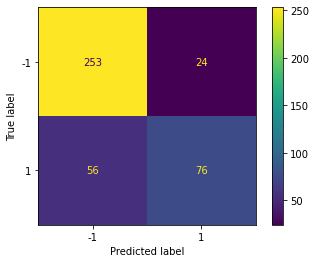

False Negative Rate (FNR): 0.42424242424242425


In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for the best model (considering the best model from performance_df)
best_model = lr_best
best_model.fit(x1_train, y1_train)
best_predictions = best_model.predict(x1_test)

conf_matrix = confusion_matrix(y1_test, best_predictions)
fnr = conf_matrix[1, 0] / (conf_matrix[1, 0] + conf_matrix[1, 1])

print("Confusion Matrix:")
print(conf_matrix)
ConfusionMatrixDisplay(conf_matrix, display_labels=best_model.classes_).plot()
pl.show()
print("False Negative Rate (FNR):", fnr)


*Comment:* It would be better to have a low False Negative Rate, especially in the medical case. Indeed, a high FNR would mean that many diabetic cases were classified as non diabetics.

4. *Since a false negative can have an important medical impact, propose a new threshold for the predicted score that leads to a FNR of less that 10% (this can be done by changing manually the value of the intercept_ in the trained classifier).*

In [37]:
# Determine the threshold that leads to FNR < 10%
desired_fnr = 0.1
optimal_threshold = (conf_matrix[1, 0] - desired_fnr * conf_matrix[1, 1]) / (desired_fnr * conf_matrix[1, 0])

print("Optimal Threshold for FNR < 10%:", optimal_threshold)


Optimal Threshold for FNR < 10%: 8.642857142857142


# Predicting Classes on the Digits dataset

You already used this dataset in a previous session so it is assumed that you already know its properties.
The data is already split in training/test sets.

## Evaluate the different supervised methods

For at least the following classifiers LinearDiscriminantAnalysis,LogisticRegression,SVC,MLPClassifier do the following.


1. *Fit the model with the default parameters and compute its prediction performance (accuracy on test data).*

**LinearDiscriminantAnalysis**

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Train LDA classifier with default parameters
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(x2, y2)

# Evaluate accuracy on test data
accuracy_lda = lda_classifier.score(xt2, yt2)


**LogisticRegression**

In [39]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression classifier with default parameters
lr_classifier = LogisticRegression()
lr_classifier.fit(x2, y2)

# Evaluate accuracy on test data
accuracy_lr = lr_classifier.score(xt2, yt2)


**SupportVectorClassifier**

In [40]:
from sklearn.svm import SVC

# Train SVC classifier with default parameters
svc_classifier = SVC()
svc_classifier.fit(x2, y2)

# Evaluate accuracy on test data
accuracy_svc = svc_classifier.score(xt2, yt2)


**MLPClassifier**

In [41]:
from sklearn.neural_network import MLPClassifier

# Train MLP classifier with default parameters
mlp_classifier = MLPClassifier()
mlp_classifier.fit(x2, y2)

# Evaluate accuracy on test data
accuracy_mlp = mlp_classifier.score(xt2, yt2)


2. *Do a quick validation of some of the important parameters (manually or with sklearn classes) to get a better performance if possible.*

AND

3. *Store the model and the accuracy for the best parameter configuration.*

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [43]:
models = []
accuracies = []
balanced_accuracies = []
F1 = []

In [44]:
n_grid = 20
seed = 123
np.random.seed(seed)

**LinearDiscriminantAnalysis**

In [45]:
model = LinearDiscriminantAnalysis()
param_grid={"shrinkage":[None, 'auto', np.linspace(0,1,n_grid)],"solver":['svd', 'lsqr', 'eigen']}

lda_cv = GridSearchCV(model, param_grid, cv=5)
lda_cv.fit(x2, y2)

lda_opt = lda_cv.best_estimator_
params_opt_lda = lda_cv.best_params_
print(f"Optimal value of shrinkage: {params_opt_lda['shrinkage']}")
print(f"Optimal solver: {params_opt_lda['solver']}")

pred_lda = lda_opt.predict(xt2)
acc_lda = accuracy_score(yt2,pred_lda)
bal_acc_lda = balanced_accuracy_score(yt2,pred_lda)
f1_lda = f1_score(yt2, pred_lda, labels=lda_opt.classes_, average="macro")
print(f"Accuracy: {acc_lda}")

Optimal value of shrinkage: auto
Optimal solver: lsqr
Accuracy: 0.9433333333333334


In [46]:
models.append("LDA")
accuracies.append(acc_lda)
balanced_accuracies.append(bal_acc_lda)
F1.append(f1_lda)

**LogisticRegression**

In [47]:
model = LogisticRegression(penalty='l1',random_state=seed,solver='saga')
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.linspace(0.1,5,10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lr_cv = GridSearchCV(model, param_grid)
lr_cv.fit(x2, y2)

lr_opt = lr_cv.best_estimator_
params_opt_lr = lr_cv.best_params_
print(f"Optimal value of C: {params_opt_lr['C']}")
print(f"Optimal solver: {params_opt_lr['solver']}")
print(f"Optimal penalty: {params_opt_lr['penalty']}")

pred_lr = lr_opt.predict(xt2)
acc_lr = accuracy_score(yt2,pred_lr)
bal_acc_lr = balanced_accuracy_score(yt2,pred_lr)
f1_lr = f1_score(yt2, pred_lr, labels=lr_opt.classes_, average="macro")
print(f"Accuracy: {acc_lr}")

Optimal value of C: 5.0
Optimal solver: liblinear
Optimal penalty: l2
Accuracy: 0.966


In [48]:
models.append("Logistic Regression")
accuracies.append(acc_lr)
balanced_accuracies.append(bal_acc_lr)
F1.append(f1_lr)

**SupportVectorClassifier**

In [49]:
model = SVC(random_state=seed)
param_grid = {
    'C': np.linspace(0.1,5,20),
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc_cv = GridSearchCV(model, param_grid, cv=3)
svc_cv.fit(x2, y2)

svc_opt = svc_cv.best_estimator_
params_opt_svc = svc_cv.best_params_
print(f"Optimal value of C: {params_opt_svc['C']}")
print(f"Optimal value of gamma: {params_opt_svc['gamma']}")
print(f"Optimal kernel: {params_opt_svc['kernel']}")


pred_svc = svc_opt.predict(xt2)
acc_svc = accuracy_score(yt2,pred_svc)
bal_acc_svc = balanced_accuracy_score(yt2,pred_svc)
f1_svc = f1_score(yt2, pred_svc, labels=svc_opt.classes_, average="macro")
print(f"Accuracy: {acc_svc}")

Optimal value of C: 4.484210526315789
Optimal value of gamma: 0.01
Optimal kernel: rbf
Accuracy: 0.9853333333333333


In [50]:
models.append("SVC")
accuracies.append(acc_svc)
balanced_accuracies.append(bal_acc_svc)
F1.append(f1_svc)

**MLPCLassifier**

In [51]:
# Define the hyperparameters and their values
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive'],
}

# Initialize the MLPClassifier
model = MLPClassifier(random_state=seed)

# Initialize the GridSearchCV
mlp_cv = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
mlp_cv.fit(x2, y2)

mlp_opt = mlp_cv.best_estimator_
params_opt_mlp = mlp_cv.best_params_
print(f"Optimal value of alpha: {params_opt_mlp['alpha']}")
print(f"Optimal hidden layers sizes: {params_opt_mlp['hidden_layer_sizes']}")
print(f"Optimal activation function: {params_opt_mlp['activation']}")
print(f"Optimal solver: {params_opt_mlp['solver']}")


pred_mlp = mlp_opt.predict(xt2)
acc_mlp = accuracy_score(yt2,pred_mlp)
bal_acc_mlp = balanced_accuracy_score(yt2,pred_mlp)
f1_mlp = f1_score(yt2, pred_mlp, labels=mlp_opt.classes_, average="macro")
print(f"Accuracy: {acc_mlp}")

Optimal value of alpha: 0.1
Optimal hidden layers sizes: (100,)
Optimal activation function: relu
Optimal solver: adam
Accuracy: 0.9826666666666667


In [52]:
models.append("MLP")
accuracies.append(acc_mlp)
balanced_accuracies.append(bal_acc_mlp)
F1.append(f1_mlp)

## Interpreting the classifier

1. *Compare the performances of the different methods (with different metrics). Which model is the best on test data?*





In [53]:
methods = ['LDA', 'Logistic Regression', 'SVC', 'MLP']
accuracies = [accuracy_lda, accuracy_lr, accuracy_svc, accuracy_mlp]

# Compare accuracies
print("Model Comparisons:")
for method, accuracy in zip(methods, accuracies):
    print(f"{method}: {accuracy:.2f}")


Model Comparisons:
LDA: 0.93
Logistic Regression: 0.97
SVC: 0.98
MLP: 0.98


Above, you can find the accuracies of the default models.

In [54]:
data = pd.DataFrame(columns=["Model", "Accuracy", "Balanced Accuracy", "F1"])
data["Model"] = models
data["Accuracy"] = accuracies
data["Balanced Accuracy"] = balanced_accuracies
data["F1"] = F1
data

,Model,Accuracy,Balanced Accuracy,F1
0,LDA,0.933333,0.943333,0.943509
1,Logistic Regression,0.965333,0.966000,0.965959
2,SVC,0.983333,0.985333,0.985321
3,MLP,0.981333,0.982667,0.982658


*Comment:* Then the optimized SVC achieves the best results on test data, because it has the best accuracy, the best balanced accuracy and the best F1 score, so the best of the three performance metrics. However, the MLP has quite similar matrics results than the SVC model, therefore the choice of the model can also depend on the computational cost, ...

2. *Select the best classifier from the previous section and use it to predict labels on the test data.*

In [55]:
# Select the best classifier (for example, SVC with tuned parameters)
best_classifier = svc_opt
best_classifier.fit(x2, y2)

# Evaluate accuracy on test data
accuracy_best_classifier = best_classifier.score(xt2, yt2)

3. *Compute the confusion matrix and interpret the errors made by the classifier. What is the class that is the most difficult to recognize? Are there somme classes that are harder to discriminate?*

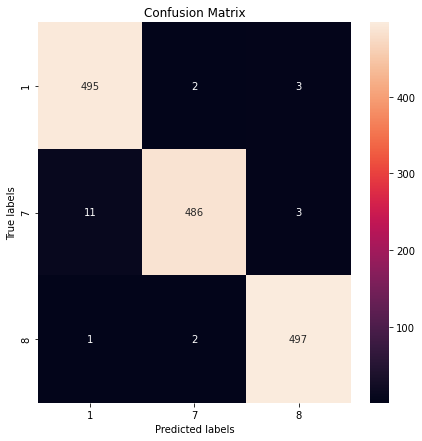

In [56]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(7,7))
pred = best_classifier.predict(xt2)
cm = confusion_matrix(yt2, pred, labels=best_classifier.classes_)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['1', '7','8']); ax.yaxis.set_ticklabels(['1', '7','8']);

*Comment:* We evaluate the recall value and the confusion matrix to assess the prediction quality for each class and identify the classes that pose recognition challenges.

Class "8" exhibits the highest precision value. In the confusion matrix, a single sample was misclassified as "1" and two others as "7".

Classes "1" and "8" share quite identical precision values. For class "1", 2 samples were misclassified as "7" and 3 samples as "8". It's worth noting the resemblance between classes "7" and "1" due to their inclined shapes. For class "8", 2 samples were misclassified as "7" and 1 sample as "1".

From this analysis, we can infer that class "7" is the most challenging to recognize.

In terms of classes that are difficult to distinguish, we have class "7", with 11 samples from class incorrectly classified as "1", and 3 samples from class "7" incorrectly classified as "8".

4. *Plot some of the sample that are miss-classified. Are they difficult to recognize ? Why did the classifier fail to recognize them?*

In [57]:
from numpy.random import randn

In [58]:
index1 = [(i, pred[i]) for i in range(len(yt2)) if yt2[i] != pred[i] and yt2[i]==1]
index7 = [(i, pred[i]) for i in range(len(yt2)) if yt2[i] != pred[i] and yt2[i]==7]
index8 = [(i, pred[i]) for i in range(len(yt2)) if yt2[i] != pred[i] and yt2[i]==8]

**Misclassified images from class "1"**

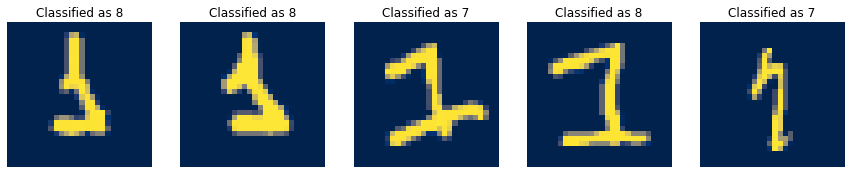

In [59]:
plt.figure(figsize=(15, 5))
for i,m in enumerate(index1):
  ind, label = m
  plt.subplot(1, 5, i+1)
  plt.imshow(xt2[ind].reshape((28,28)),cmap="cividis")
  pl.title(f"Classified as {label}")
  pl.axis('off')

*Comment:* The samples that was identified as "7" bears a strong resemblance to the numeral "7", particularly due to its slanted lines. The other samples, which was categorized as "8", possesses a curve that might have misled the classifier into classifying it as "8".

**Misclassified images from class "7"**

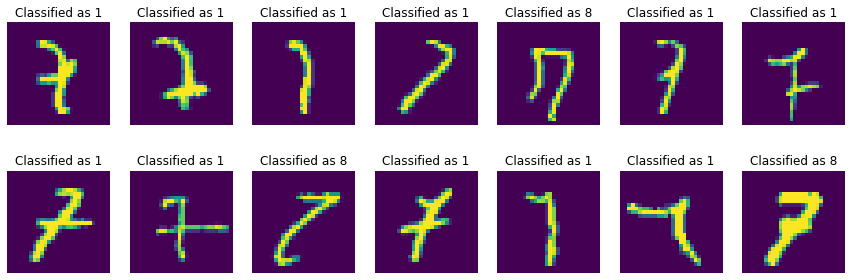

In [60]:
plt.figure(figsize=(15, 5))
for i,m in enumerate(index7): # limit to 10 items
  ind,label = m
  pl.subplot(2, 7, i+1)
  pl.imshow(xt2[ind].reshape((28,28)),cmap="viridis")
  pl.title(f"Classified as {label}")
  pl.axis('off')


*Comment:* We observe that the numerals identified as "1" exhibit a slender vertical form, akin to the images in class "1". Hence, we can notice that the "7" is more misclassified as "1" than "1" as "7".
For instance, even to the human eye, it's challenging to discern that the final sample is part of class "7".

In the case of other images, such as those classified as "8", we notice the existence of curve, which was categorized as "8".

**Misclassified images from class "8"**

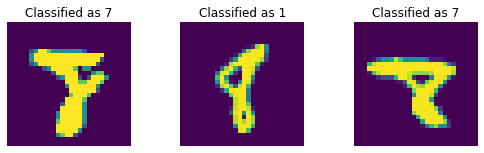

In [61]:
plt.figure(figsize=(15, 5))
for i,m in enumerate(index8):
  ind,label = m
  plt.subplot(2, 5, i+1)
  plt.imshow(xt2[ind].reshape((28,28)),cmap="viridis")
  pl.title(f"Classified as {label}")
  pl.axis('off')

*Comment:* Finally, images identified as "7" exhibit straight lines oriented horizontally and vertically. On the other hand, images classified as "1" tend to have a slender and predominantly vertical form.

5. *Pick a well classified sample and create 1000 noisy samples of it by adding gaussian noise (np.random.randn). Pick a level of noise that allows you to still distinguish clearly the class. Compute the accuracy of the classifier on those 1000 noisy samples. If the accuracy is 1, increase the noise level or choose another well classified sample.*

In [62]:
ind=1015
im = xt2[ind]

In [63]:
true_labels = yt2[ind]*np.ones((1000,1))
sig = np.linspace(0.1,5,40)
std_to_acc = {}
std_to_samples = {}
std_to_preds = {}

for s in sig:
  adversarial = im
  for i in range(1000):
    x = s*randn(28*28)
    im_new = im + x
    adversarial = np.vstack( (adversarial, im_new) )
  adversarial = adversarial[1:,:]
  std_to_samples[s] = adversarial
  adv_pred = mlp_opt.predict(adversarial)
  std_to_preds[s] = adv_pred
  acc_adv = accuracy_score(true_labels, adv_pred)
  std_to_acc[s] = acc_adv

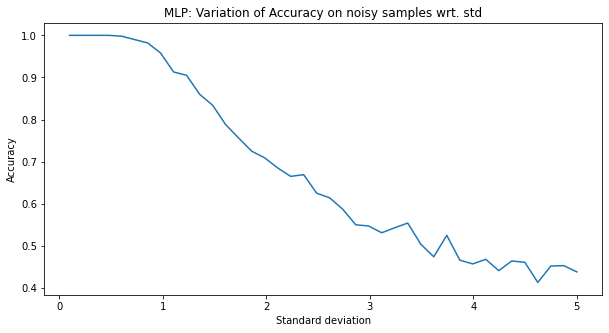

In [64]:
plt.figure(figsize=(10, 5))
pl.plot(sig,list(std_to_acc.values()))
pl.title("MLP: Variation of Accuracy on noisy samples wrt. std")
pl.xlabel("Standard deviation")
pl.ylabel("Accuracy")
pl.show()

In [65]:
true_labels = yt2[ind]*np.ones((1000,1))
sig = np.linspace(0.1,5,40)
std_to_acc = {}
std_to_samples = {}
std_to_preds = {}

for s in sig:
  adversarial = im
  for i in range(1000):
    x = s*randn(28*28)
    im_new = im + x
    adversarial = np.vstack( (adversarial, im_new) )
  adversarial = adversarial[1:,:]
  std_to_samples[s] = adversarial
  adv_pred = best_classifier.predict(adversarial)
  std_to_preds[s] = adv_pred
  acc_adv = accuracy_score(true_labels, adv_pred)
  std_to_acc[s] = acc_adv

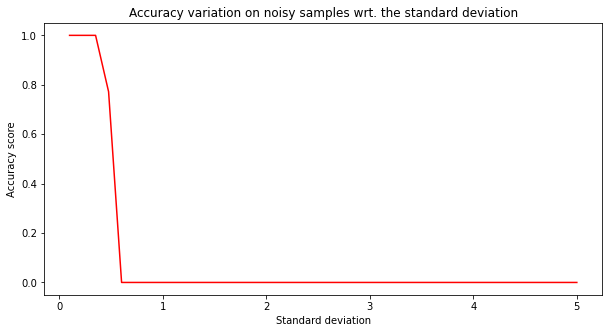

In [66]:
plt.figure(figsize=(10, 5))
pl.plot(sig, list(std_to_acc.values()), color='red')
pl.title("Accuracy variation on noisy samples wrt. the standard deviation")
pl.xlabel("Standard deviation")
pl.ylabel("Accuracy score")
pl.show()


*Comment:* It is evident that by escalating the standard deviation, we can manipulate the model. The accuracy continues to decline as we progressively augment the value of the standard deviation.

For example, for the MLP, the classifier can be deemed fairly resilient. The accuracy maintained a high value, nearly 1, until we elevated the standard deviation to 1. To illustrate some of the adversarial samples, we opt for a standard deviation value that results in an accuracy less than 1.

Otherwise, for SVC best classifier, the accuracy will be null from approximately 0.75 for the standard deviation.

6. *How robust is the classifier? Visualise some of those "adversarial" examples when the accuracy on the noisy samples is not 1.*

In [76]:
std=0.6025641025641025
robust = std_to_acc[std]

It can be stated that the classifier demonstrates considerable robustness. The accuracy maintained a high value, nearing 1, as we escalated the standard deviation to 1. To display some of the adversarial samples, we selected a standard deviation value that resulted in an accuracy less than 1.

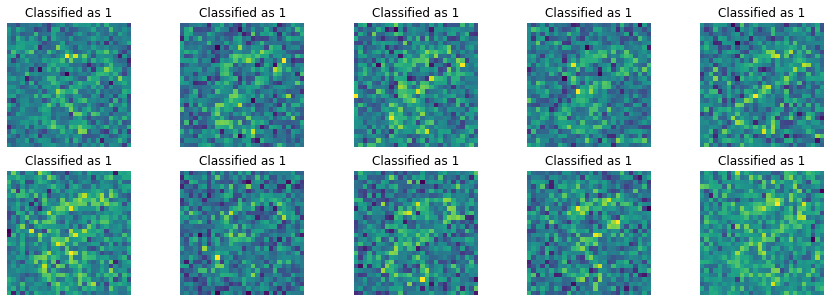

In [68]:
x = std_to_samples[std]
pred_x = std_to_preds[std]
index_adversarial = [i for i in range(1000) if pred_x[i]!=yt2[ind]]

plt.figure(figsize=(15, 5))
for i,indx in enumerate(index_adversarial[:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(x[indx].reshape((28,28)))
  pl.title(f"Classified as {pred_x[indx]}")
  pl.axis('off')

# Bonus: Convolutional Neural network (CNN)

*Implement a CNN and train it on the data (you will need to reshape it to store it as images). Investigate the performance of the CNN when varying its parameters. Does it have better performance than the model above? Is it more robust to adversarial examples?.*

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Assuming x2 and xt2 are your existing data
num_images = x2.shape[0]  # replace with actual number of images
img_height = 28  # replace with actual image height
img_width = 28  # replace with actual image width

# Reshape data for CNN
x_train_cnn = x2.reshape(num_images, img_height, img_width, 1).astype('float32')
x_test_cnn = xt2.reshape(xt2.shape[0], img_height, img_width, 1).astype('float32')

# One-hot encode the labels
y_train_cnn = to_categorical(y2, 10)
y_test_cnn = to_categorical(yt2, 10)

# Define CNN architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_data=(x_test_cnn, y_test_cnn))

# Evaluate the model
accuracy_cnn = model.evaluate(x_test_cnn, y_test_cnn)[1]
print(f"Accuracy of CNN: {accuracy_cnn:.4f}")


Epoch 1/10
94/94 [==============================] - 1s 12ms/step - loss: 0.1782 - accuracy: 0.9477 - val_loss: 0.0737 - val_accuracy: 0.9773
Epoch 2/10
94/94 [==============================] - 1s 12ms/step - loss: 0.0439 - accuracy: 0.9877 - val_loss: 0.0514 - val_accuracy: 0.9833
Epoch 3/10
94/94 [==============================] - 1s 10ms/step - loss: 0.0268 - accuracy: 0.9907 - val_loss: 0.0527 - val_accuracy: 0.9833
Epoch 4/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.0469 - val_accuracy: 0.9860
Epoch 5/10
94/94 [==============================] - 1s 8ms/step - loss: 0.0188 - accuracy: 0.9943 - val_loss: 0.0464 - val_accuracy: 0.9880
Epoch 6/10
94/94 [==============================] - 1s 8ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0419 - val_accuracy: 0.9873
Epoch 7/10
94/94 [==============================] - 1s 8ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.0627 - val_accuracy: 0.9820
Epoch 8/10
94/94

*Comment:* As the accuracy of the CNN model on test dataset is slightly higher, we can conclude that this model has better performance.

In [72]:
# Create a list of standard deviations from 0.1 to 1.0
sig = [i/10.0 for i in range(1, 11)]

acc = []
for s in sig:
    # Add noise to your test data
    x_test_noisy = x_test_cnn + np.random.normal(loc=0.0, scale=s, size=x_test_cnn.shape)
    # Evaluate your model on the noisy test data
    score = model.evaluate(x_test_noisy, y_test_cnn, verbose=0)
    # Append the accuracy to the acc list
    acc.append(score[1])


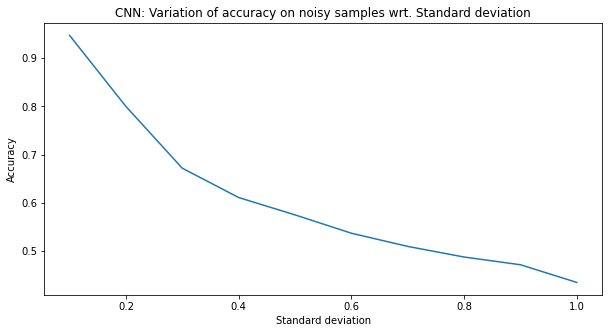

In [73]:
# Assuming acc and sig are your existing data
plt.figure(figsize=(10, 5))
plt.plot(sig, acc)
plt.title("CNN: Variation of accuracy on noisy samples wrt. Standard deviation")
plt.xlabel("Standard deviation")
plt.ylabel("Accuracy")
plt.show()


*Comment:* It is observed that the CNN model doesn't hold up as well against adversarial samples compared to the MLP model. As the values of standard deviations rise, the accuracy of the CNN model diminishes at a quicker rate.

# Personal Discussion

1. **Understanding and Implementation:** Classification is obviously a fundamental concept in machine learning, and it can be challenging to grasp all the nuances of different models and techniques. In this session, personally for the first time, we have worked with a variety of models, from linear ones like Logistic Regression and LDA to non-linear ones like Random Forests and Neural Networks. Implementing these models requires a solid understanding of both the models and the practical aspects of coding, therefore it was really interesting to implement and optimize all these differents models.


2. **Future Approaches:** Next time, we could try to experiment with different feature engineering techniques or try out other models on more complex datasets. Also, we could consider spending more time on the interpretability of our models, especially in case of a professional analysis. Hence, understanding why a model makes certain predictions can be just as important as the predictions themselves.


3. **New Learnings:** This session introduced me to some new models implementations and techniques. However, the most accurate model CNN, which is powerful tool for tackling complex, non-linear problems, was already implemented personally.


4. **Course Relation:** As the previous practical sessions, this one is a direct application of the theories and techniques, we have evoked in the course. But, again, it gives us hands-on experience with the models and allows us to see how they perform on real-world data.


5. **Professional Application:** Finally, during this course, the skills we have reviewed or learned are highly valuable in the professional world. Indeed, the practical aspect of Machine Learning can be most of the time more useful than just its theoritical aspects. Moreover, classification models are used in a wide range of industries, from healthcare to finance to marketing. Being able to build, evaluate, and interpret these models can give us a valuable asset to any data-driven organization.